## Engenharia de Software para Ciência de Dados - PUC-Rio
# Projeto final
###Probabilidade de séries e filmes estarem em um dos serviços de streaming - Classificação multiclass

![Image in a markdown cell]( https://br.web.img2.acsta.net/r_654_368/newsv7/21/03/31/20/51/1394456.jpg)


Felipe Neves

### 1. Definição do Problema

Como usuário de serviços de streaming, quero saber qual a probabilidade de certo filme ou série estar presente em uma das plataformas de streaming (Netflix, Amazon, Disney)

*   #### Descrição detalhada
*   Tipo de problema de machine learning: Classificação multiclass
*   Entrada(as):
1. **show_id** - id único do filme/série por streaming
2. **type** - filme ou série
3. **title** - Título de filme ou série
4. **director** - Diretor da obra
5. **cast** - atrizes e atores presentes na obra
6. **country** - País de origem
7. **date_add** - data em que a obra foi adicionada no seviço de streaming
8. **release_year** - Data de lançamento
9. **rating** - Rating de classificação de audiência
10. **duration** - Duração de filmes (em minutos) ou séries (em temporadas)
11. **listed_in** - classificada como
12. **description** - breve descrição sobre a obra
13. **streaming** - streaming vinculado
* Saída(s):  Clasificação em formato de probabilidade de certo filme ou série estar presente em uma das três plataformas de streaming consideradas
*   Fonte de dados: três datasets presentes no kagle com informações de séries e filmes lançadas em cada um dos três serviços de streaming disponíveis (Netflix, Amazon e Disney). Para mais detalhes sobre estes datasets, consulte: https://www.kaggle.com/shivamb/netflix-shows, https://www.kaggle.com/shivamb/amazon-prime-movies-and-tv-shows, https://www.kaggle.com/shivamb/disney-movies-and-tv-shows
*   Dinâmica de criação e atualização dos modelos: Sob demanda
*   Dinâmica da execução do modelo: Sob demanda
*   Avaliação offiline do modelo: Utilização de base de testes atualizados para validar o modelo em dados não vistos
durante o treinamento (hold-out)
*   Monitoramente online do modelo: : Desnecessário no momento
*   Características de qualidade desejadas: Qualidade dos dados (representatividade estatística da
amostra, estratificação correta da base de treino e teste); Fairness/Ética (evitar viés de discriminação)



### 2. Importar dados
Iremos usar o pacote Pandas para carregar a série de datasets necessários.
Como cada um destes datasets estão separados, vamos  criar um rótulo para cada um dos serviços de streaming, e unir todos eles em um dataset único

#### 2.1 Importar bibliotecas, paramêtros e classes


In [ ]:
%%capture
#Instalar packages necessários
!pip install plotly --upgrade
!pip install catboost
!pip install category_encoders
!pip install optuna

#Depois, importar packages
#manipulação de dados
import pandas as pd
import numpy as np
import random

#import visualization
import missingno as msno
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly as py
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

#importar preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import make_scorer
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.woe import WOEEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#importar modelos
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

#importar métricas
from sklearn.metrics import hamming_loss, balanced_accuracy_score
from scipy.stats import ks_2samp
from sklearn.compose import ColumnTransformer
#tuning de hiperparamêtros
import optuna

#exportar resultados
import pickle

In [ ]:
#parametros
target = 'target'

max_nulos = 0.25
corte_samples = 0.0005
n_folds = 5
random_state = 42
pio.templates.default = "plotly_white"

sns.set_style("whitegrid")
#plt.style.use('classic')

In [ ]:
#classes
class Loader:

    def load_data(self, url: str, sep: str):
        """ Carrega e retorna um dataset.
        Há diversos parâmetros no read_csv para dar opções adicionais.
        """
        df = pd.read_csv(url, sep)
        print(df.shape)
        return df

    def verify(self, df):
        print(df.shape)
        return df.head()

    def join_data(self, dataset_1, dataset_2, dataset_3):
      """ Retorna os datesets em um só.
        """
      return pd.concat([dataset_1, dataset_2, dataset_3]).reset_index(drop=True)

 ##################################################################################

class PreProcessor:

    def preprocess(self, dataset, test_size, random_state):
        """ Cuida de todo o pré-processamento. """
        # limpeza dos dados
        # divisão em treino e teste
        X_train, X_test, Y_train, Y_test = self.__prepare_holdout(dataset,
                                                                  test_size,
                                                                   random_state=random_state)
        # normalização/padronização
        return (X_train, X_test, Y_train, Y_test)

    def __prepare_holdout(self, dataset, test_size, random_state):
        """ Divide os dados em treino e teste usando o método holdout.
        O parâmetro test_size é o percentual de dados de teste.
        """
        X = dataset.drop(columns = ['target'])
        Y = dataset.target
        return train_test_split(X, Y, test_size=test_size, random_state=random_state)

    def nulos(self, dataset, max_nulos):
        """ Remove colunas com certa quantia definida de nulos
        no dataset
        """
        df_aux = (dataset.isna().sum() / dataset.shape[0]).reset_index()
        mask = df_aux[0] <= max_nulos

        return dataset[df_aux.loc[mask, 'index'].unique()].copy()

    def outros(self, dataset, categoricas, corte_samples):
      """ cria a categoria outra para variaveis categoricas de acordo
      o threshold definido
      """
      for col in categoricas:
        list_sample = (dataset[col].value_counts(normalize=True) < corte_samples)
        list_sample = list_sample.reset_index().set_index(col)
        try:
          list_sample = list_sample.drop(False, axis=0)
        except:
          None
        list_sample = list_sample['index'].unique().tolist()

        mask = dataset[col].isin(list_sample)
        dataset.loc[mask, col] =  dataset.loc[mask, col] = 'Outros'
        return dataset

#####################################################################################

class Model_tuning(object):

  def __init__(self, X_train, y_train):
    self.X_train = X_train
    self.Y_train = Y_train

  def __call__(self, trial):

        param = {
        'n_estimators': trial.suggest_int( 'n_estimators',  10,1000,200),
        'max_features': trial.suggest_categorical( 'max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_categorical('max_depth',[10, 20, 30,None]),
        'bootstrap': trial.suggest_categorical('bootstrap',[True, False]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,9,2),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'criterion':trial.suggest_categorical('criterion',['gini', 'entropy']),
        'verbose':trial.suggest_categorical('verbose',[0])
        }

        pipe = Pipeline([('encoder', enc), ('scalar', sca), ('imputer', imp), ('classifier', OneVsRestClassifier(RandomForestClassifier(**param), n_jobs=-1))])

        return cross_val_score(pipe, X_train, Y_train, cv=n_folds,scoring='balanced_accuracy').mean()

In [ ]:
#Instanciar classes que são necessarias a priori
Loader = Loader()
PreProcessor = PreProcessor()

#### 2.2 Carregar dados

In [ ]:
#importar dados, aqui já conseguimos perceber que o volume de dados é desbalanceado
df_net = Loader.load_data('https://raw.githubusercontent.com/fmarcelneves/streaming_project/main/data_streaming/netflix_titles.csv',  sep =',')
df_ama = Loader.load_data('https://raw.githubusercontent.com/fmarcelneves/streaming_project/main/data_streaming/amazon_prime_titles.csv',  sep =',')
df_dis = Loader.load_data('https://raw.githubusercontent.com/fmarcelneves/streaming_project/main/data_streaming/disney_plus_titles.csv', sep =',')

(8807, 12)
(9668, 12)
(1450, 12)


In [ ]:
#rotular dados que faram parte do nosso target
df_net['streaming'] = 'netflix'
df_ama['streaming'] = 'amazon'
df_dis['streaming'] = 'disney'

In [ ]:
#criar df com todos os serviços
df = Loader.join_data(df_net, df_ama, df_dis)

### 3. Análise de dados

#### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e conferir os dados

In [ ]:
# Mostra as dimensões do dataset
print(df.shape)

(19925, 13)


In [ ]:
# Mostra as informações do dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       19925 non-null  object
 1   type          19925 non-null  object
 2   title         19925 non-null  object
 3   director      14736 non-null  object
 4   cast          17677 non-null  object
 5   country       9879 non-null   object
 6   date_added    10399 non-null  object
 7   release_year  19925 non-null  int64 
 8   rating        19581 non-null  object
 9   duration      19922 non-null  object
 10  listed_in     19925 non-null  object
 11  description   19925 non-null  object
 12  streaming     19925 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.0+ MB
None


In [ ]:
#modificar variaveis relacionadas a tempo para datetime objects do pandas
df['date_added'] =  pd.to_datetime(df['date_added'])
df['release_year'] = pd.to_datetime(df.release_year, format='%Y')

In [ ]:
#criar target em formato númerico
df['target'] = np.nan
df.loc[(df.streaming == 'netflix'), 'target'] = 1
df.loc[(df.streaming == 'amazon'), 'target'] = 2
df.loc[(df.streaming == 'disney'), 'target'] = 3

In [ ]:
df.target.value_counts()

2.0    9668
1.0    8807
3.0    1450
Name: target, dtype: int64

In [ ]:
#verificar dados
Loader.verify(df)

(19925, 14)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,streaming,target
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020-01-01,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",netflix,1.0
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021-01-01,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",netflix,1.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021-01-01,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,netflix,1.0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021-01-01,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",netflix,1.0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021-01-01,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,netflix,1.0


In [ ]:
#Existem muitos nulos no dataset?
nulos_total = pd.DataFrame(df.isnull().mean() * 100, columns=['Total'])
nulos_netflix = pd.DataFrame(df[df['streaming'] == 'netflix'].isnull().mean() * 100, columns=['Netflix'])
nulos_amazon = pd.DataFrame(df[df['streaming'] == 'amazon'].isnull().mean() * 100, columns=['Amazon'])
nulos_disney = pd.DataFrame(df[df['streaming'] == 'disney'].isnull().mean() * 100, columns=['Disney'])
nulos = pd.concat([nulos_total, nulos_netflix, nulos_amazon, nulos_disney], axis=1)
nulos.style.background_gradient(cmap='Greens')

,Total,Netflix,Amazon,Disney
show_id,0.000000,0.000000,0.000000,0.000000
type,0.000000,0.000000,0.000000,0.000000
title,0.000000,0.000000,0.000000,0.000000
director,26.042660,29.908028,21.534961,32.620690
cast,11.282309,9.367549,12.753413,13.103448
country,50.419072,9.435676,93.049235,15.103448
date_added,47.809285,0.113546,98.396773,0.206897
release_year,0.000000,0.000000,0.000000,0.000000
rating,1.726474,0.045418,3.485726,0.206897
duration,0.015056,0.034064,0.000000,0.000000


verificamos nulos no dataset, comparados os datasets individuos, vimos que no dataset da amazon, existem duas categorias com mais de 90% de nulos, além de quase 50% no dataset da Netflix (country e data_added) apesar de podermos analisa-las em conjunto com os outros datasets,
não convem usar essas duas variáveis no modelos, vamos deixar isso em mente

In [ ]:
# por fim, podemos verificar se existem linhas duplicadas, como não é necessário retirar duplicatas
print('Linhas duplicatas -  total', df.duplicated().sum())
print('duplicatas de títulos - total', df.title.duplicated().sum())
mask = df.streaming == 'netflix'
print('duplicatas de títulos - netflix', df[mask].title.duplicated().sum())
mask = df.streaming == 'amazon'
print('duplicatas de títulos - amazon', df[mask].title.duplicated().sum())
mask = df.streaming == 'disney'
print('duplicatas de títulos -  disney', df[mask].title.duplicated().sum())

Linhas duplicatas -  total 0
duplicatas de títulos - total 447
duplicatas de títulos - netflix 0
duplicatas de títulos - amazon 0
duplicatas de títulos -  disney 0


Através das nossas primeiras inferências sobre o dataset, podemos criar variaveis mais informativas para estudar melhor os dados

In [ ]:
#criar diferença entre anos
df['dif_year_add'] =  df.date_added.dt.year - df.release_year.dt.year

#criar novas variaveis discretizando melhor algumas variveis existentes
df['listed_in_main'] = df['listed_in'].str.split(',').str[0]
df['cast_main'] = df['cast'].str.split(',').str[0]
df['country_main'] = df['country'].str.split(',').str[0]
df['director_main'] = df['director'].str.split(',').str[0]

#criar count variables baseadas em variveis de string
df['director_number'] = df.director.astype(str).str.split(',').apply(len)
df['cast_number'] = df.cast.astype(str).str.split(',').apply(len)
df['listed_in_number'] = df.listed_in.astype(str).str.split(',').apply(len)
df['country_number'] = df.country.astype(str).str.split(',').apply(len)

#duração tempo
df['duration'] = df.duration.str.replace(r'\D', '').astype(float)

In [ ]:
#por fim, vamos dar um describe nas variaveis numéricas
df.describe()

,duration,target,dif_year_add,director_number,cast_number,listed_in_number,country_number
count,19922.000000,19925.000000,10399.00000,19925.000000,19925.000000,19925.000000,19925.000000
mean,70.682211,1.630765,6.36417,1.080201,5.853952,2.084918,1.125069
std,50.697479,0.615195,12.18217,0.423762,4.892423,0.883506,0.512949
min,0.000000,1.000000,-3.00000,1.000000,1.000000,1.000000,1.000000
25%,7.000000,1.000000,0.00000,1.000000,2.000000,1.000000,1.000000
50%,86.000000,2.000000,1.00000,1.000000,5.000000,2.000000,1.000000
75%,103.000000,2.000000,7.00000,1.000000,8.000000,3.000000,1.000000
max,601.000000,3.000000,93.00000,17.000000,76.000000,5.000000,15.000000


Vamos agora verificar se o dataset tem as classes balanceadas para que possamos tratar o desbalanceamento posteriormente, se necessário. Veremos que as classes 0 estão desbalanceadas, especialmente do serviço de streaming da disney. Possivelmente precisaremos realizar algum tipo de tratamento nas próximas etapas, ou uso de diferentes métricas de avaliação para o modelo

In [ ]:
print('Target normalizado - 1.Netflix, 2.Amazon, 3.Disney')
print(df.target.value_counts(normalize=True))
print('')
print('Target não normalizado - 1.Netflix, 2.Amazon, 3.Disney')
print(df.target.value_counts())

Target normalizado - 1.Netflix, 2.Amazon, 3.Disney
2.0    0.485220
1.0    0.442008
3.0    0.072773
Name: target, dtype: float64

Target não normalizado - 1.Netflix, 2.Amazon, 3.Disney
2.0    9668
1.0    8807
3.0    1450
Name: target, dtype: int64


In [ ]:
df.target.value_counts()

2.0    9668
1.0    8807
3.0    1450
Name: target, dtype: int64

In [ ]:
#vamos dividir as variaveis em suas respectivas categorias para ajudar na visualizaçao analise exploratoria
id_cols = ['show_id', 'streaming', 'listed_in', 'country', 'cast', 'director', 'description']
categoricas = df.select_dtypes(include='object').columns.tolist()
categoricas = list(set(categoricas) - set(id_cols))
numericas = df.select_dtypes(exclude=['object', 'datetime64[ns]']).columns.tolist()

### 3.2. Análise exploratória dos Dados

Vamos criar agora um histograma para cada atributo do dataset. Veremos que os atributos age, pedi e test seguem uma distribuição exponencial, e que as colunas mass e press seguem uma distribuição aproximadamente normal.

#### Dados numéricos

In [ ]:
#verificando os dados numéricos presentes no dataset
df[numericas].head()

,duration,target,dif_year_add,director_number,cast_number,listed_in_number,country_number
0,90.0,1.0,1.0,1,1,1,1
1,2.0,1.0,0.0,1,19,3,1
2,1.0,1.0,0.0,1,9,3,1
3,1.0,1.0,0.0,1,1,2,1
4,2.0,1.0,0.0,1,8,3,1


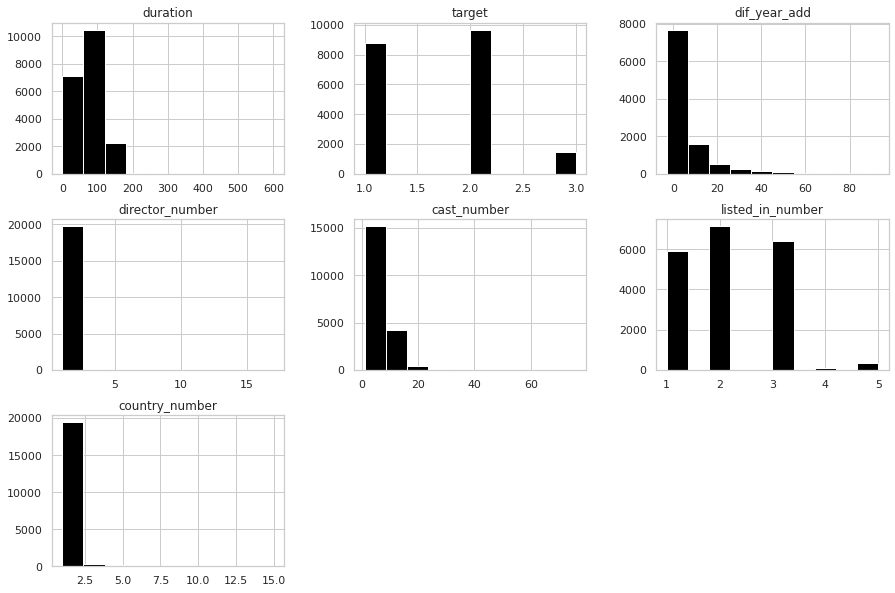

In [ ]:
# Histograma
df.hist(figsize = (15,10), color='black')
plt.show()

O Gráfico de Densidade, ou Density Plot, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, vamos criar um density plot para cada atributo do dataset.

Veremos que muitos dos atributos têm uma distribuição distorcida. Tranformações de dados como log, podem ser uteís

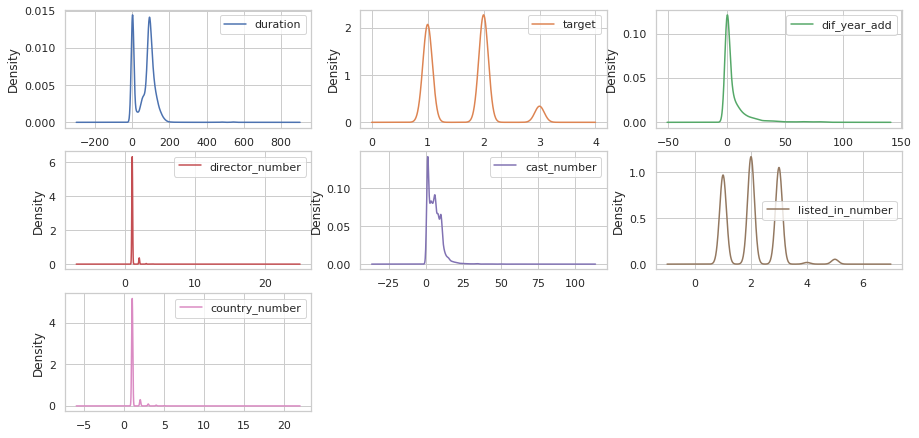

In [ ]:
# Density Plot
df[['duration', 'target', 'dif_year_add', 'director_number', 'cast_number', 'listed_in_number', 'country_number']].plot(layout = (4,3), kind = 'density', subplots = True, sharex = False, figsize = (15,10))
plt.show()

Vamos agora trabalhar com boxplots.

*OBS: Se um ponto do dataset é muito distante da média (acima de 3 desvios padrão da média), pode ser considerado outlier.*

Nos gráficos bloxplot, veremos que a dispersão dos atributos do dataset é bem diferente.

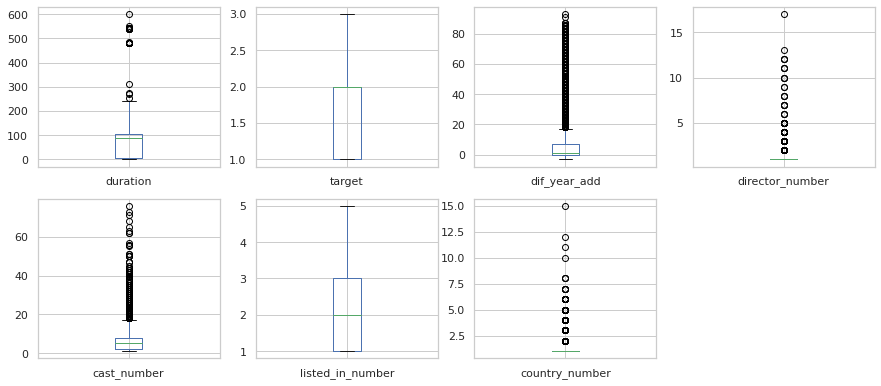

In [ ]:
# Boxplot
df.plot(kind = 'box', subplots = True, layout = (3,4), sharex = False, sharey = False, figsize = (15,10))
plt.show()

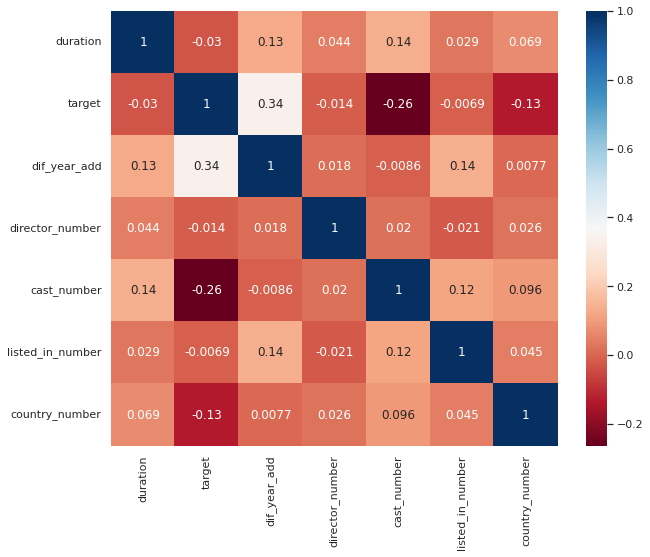

In [ ]:
#correlação
plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True,  cmap='RdBu');

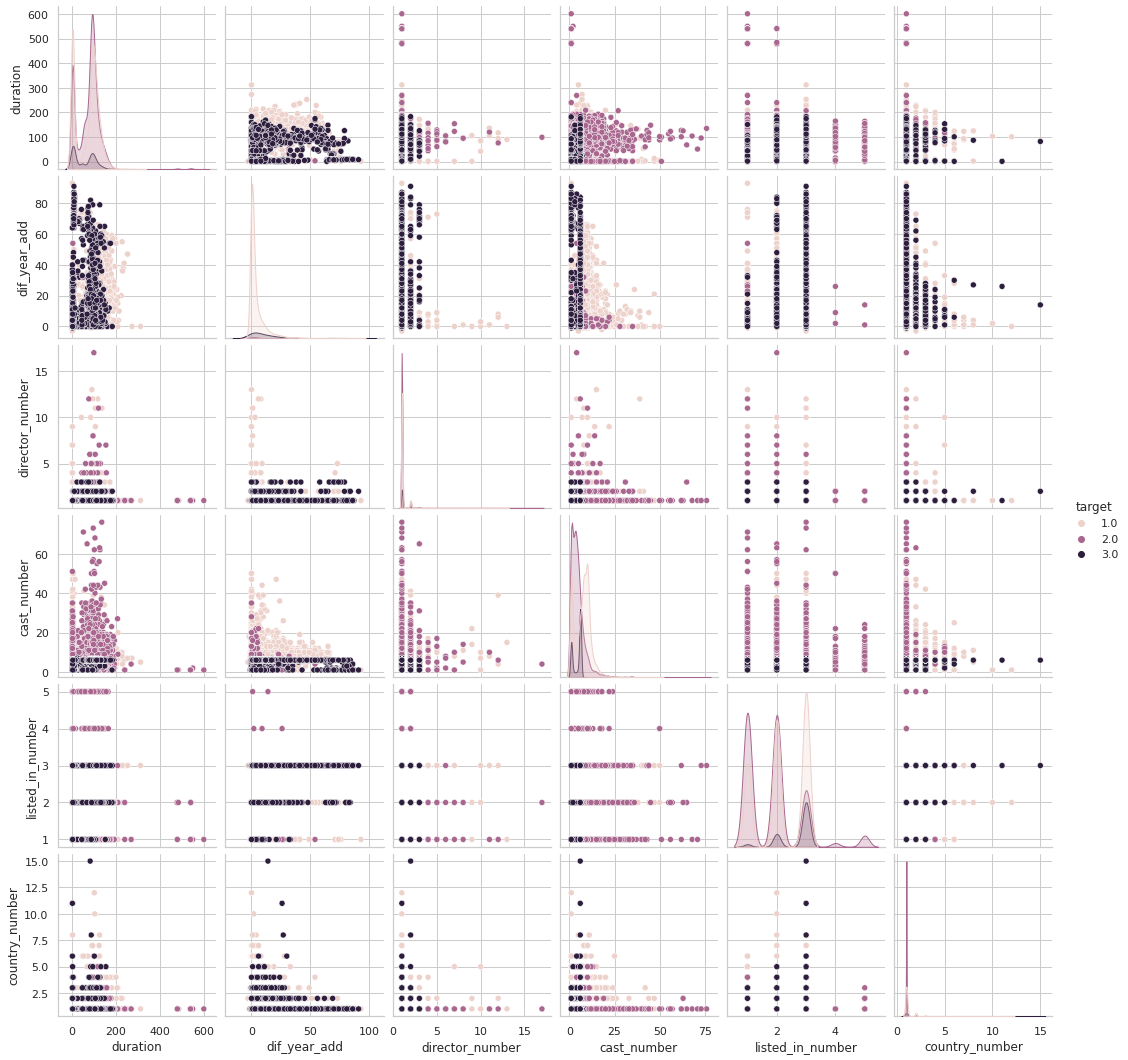

In [ ]:
sns.pairplot(df, hue='target', diag_kind='kde');

#### dados categóricos
Vamos verificar os dados categóricos presentes no dataset

In [ ]:
Loader.verify(df[categoricas])

(19925, 7)


,type,cast_main,country_main,title,director_main,listed_in_main,rating
0,Movie,NaN,United States,Dick Johnson Is Dead,Kirsten Johnson,Documentaries,PG-13
1,TV Show,Ama Qamata,South Africa,Blood & Water,NaN,International TV Shows,TV-MA
2,TV Show,Sami Bouajila,NaN,Ganglands,Julien Leclercq,Crime TV Shows,TV-MA
3,TV Show,NaN,NaN,Jailbirds New Orleans,NaN,Docuseries,TV-MA
4,TV Show,Mayur More,India,Kota Factory,NaN,International TV Shows,TV-MA


In [ ]:
#numeros de filmes e tv shows
df.type.value_counts(normalize=True)

Movie      0.752673
TV Show    0.247327
Name: type, dtype: float64

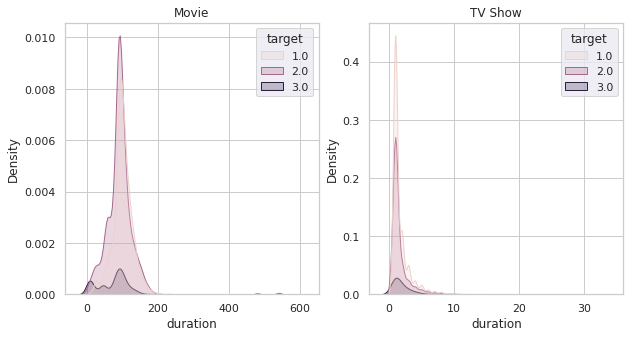

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.set(style="darkgrid")
sns.kdeplot(data=df[df.type == 'Movie'], x='duration', shade=True, hue='target', ax=axes[0])
axes[0].set_title('Movie')
sns.kdeplot(data=df[df.type == 'TV Show'], x='duration', shade=True, hue='target', ax=axes[1])
axes[1].set_title('TV Show');

In [ ]:
#Observar número de únicos em rating
df.rating.unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR', '13+', 'ALL', '18+', '16+', '7+', 'TV-NR',
       'UNRATED', '16', 'AGES_16_', 'AGES_18_', 'ALL_AGES', 'NOT_RATE'],
      dtype=object)

In [ ]:
#Corrigir ratings
dict = {'ALL_AGES': 'G', 'ALL' : 'G', '13+': 'PG-13', '18+': 'NC-17', '13+': 'PG-13', '16+': 'R', '16': 'R', '7+':'PG', 'TV-Y7-FV':'TV-Y7', '74 min': 'TV-MA', '84 min': 'TV-MA', '66 min': 'TV-MA', 'TV-NR': 'NR', 'NOT_RATE': 'UR', 'UNRATED': 'UR'}
df.replace({"rating": dict}, inplace=True)
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', nan, 'UR', 'AGES_16_', 'AGES_18_'],
      dtype=object)

In [ ]:
# Renomear valores para melhor entendimento
# Fonte : https://help.netflix.com/en/node/2064
df['rating'] = df['rating'].replace({'PG-13': 'Teens - Age above 12', 'TV-MA': 'Adults', 'AGES_18_': 'Adults', 'PG': 'Kids - parental guidence', 'TV-14': 'Teens - Age above 14',
                'AGES_16_': 'Teens - Age above 14', 'TV-PG': 'Kids - parental guidence', 'TV-Y': 'Kids', 'TV-Y7': 'Kids - Age above 7', 'R': 'Adults', 'TV-G': 'Kids', 'G': 'Kids',
                'NC-17': 'Adults', 'NR': 'NR', 'UR' : 'NR'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   show_id           19925 non-null  object        
 1   type              19925 non-null  object        
 2   title             19925 non-null  object        
 3   director          14736 non-null  object        
 4   cast              17677 non-null  object        
 5   country           9879 non-null   object        
 6   date_added        10399 non-null  datetime64[ns]
 7   release_year      19925 non-null  datetime64[ns]
 8   rating            19581 non-null  object        
 9   duration          19922 non-null  float64       
 10  listed_in         19925 non-null  object        
 11  description       19925 non-null  object        
 12  streaming         19925 non-null  object        
 13  target            19925 non-null  float64       
 14  dif_year_add      1039

In [ ]:
px.histogram(df, x='rating', color='target', histnorm='percent', barmode='group',  width=800, height=400, title = 'Rating classification of movies and tv shows')

In [ ]:
#países únicos
df.country_main.nunique()

89

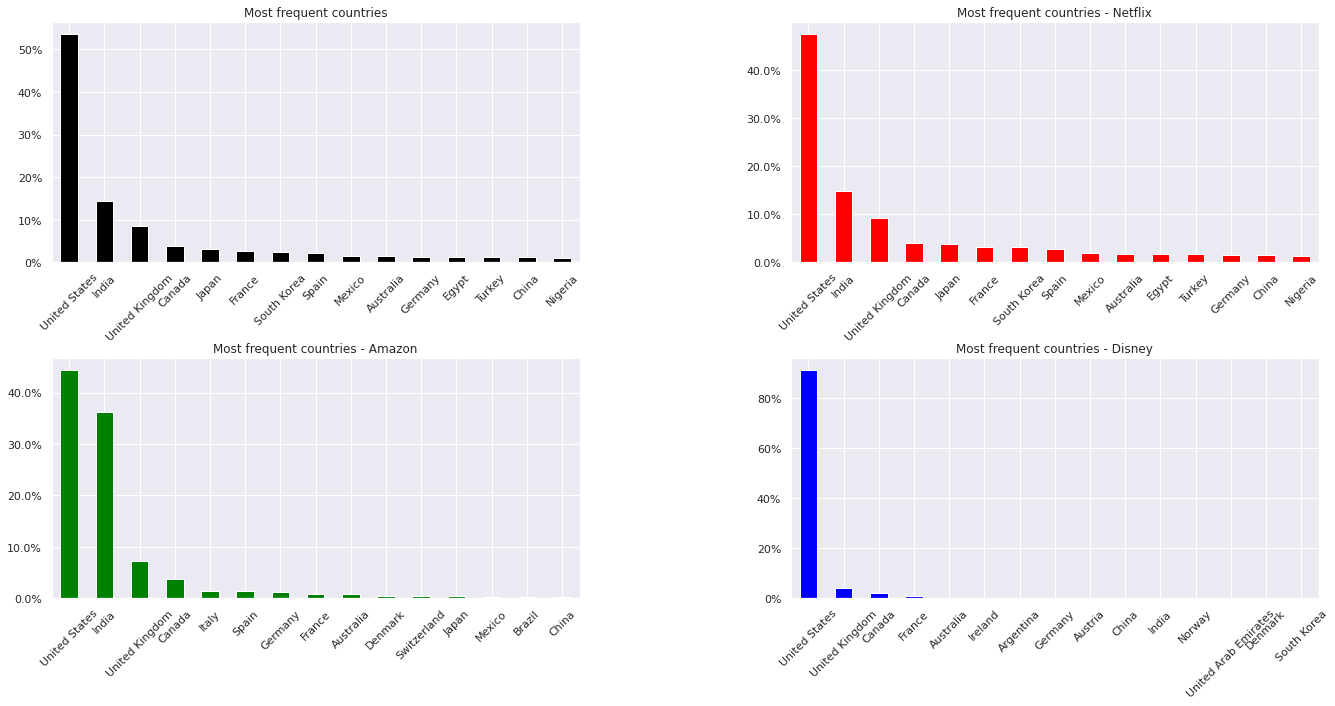

In [ ]:
#Quinze países mais frequentes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

mask = (df.country_main == 'No Data')
fig1 = df['country_main'][~mask].value_counts().nlargest(15)/df['country_main'][~mask].value_counts().nlargest(15).sum()*100
fig1 = fig1.plot(kind='bar', title="Most frequent countries", color='black', ax=axes[0, 0], rot=45)
fig1.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.country_main == 'No Data')| (df.streaming != 'netflix')
fig2 = df['country_main'][~mask].value_counts().nlargest(15)/df['country_main'][~mask].value_counts().nlargest(15).sum()*100
fig2 = fig2.plot(kind='bar', title="Most frequent countries - Netflix", color='red', ax=axes[0, 1], rot=45)
fig2.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.country_main == 'No Data')| (df.streaming != 'amazon')
fig3 = df['country_main'][~mask].value_counts().nlargest(15)/df['country_main'][~mask].value_counts().nlargest(15).sum()*100
fig3 = fig3.plot(kind='bar', title="Most frequent countries - Amazon", color='green', ax=axes[1, 0], rot=45)
fig3.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.country_main == 'No Data')| (df.streaming != 'disney')
fig4 = df['country_main'][~mask].value_counts().nlargest(15)/df['country_main'][~mask].value_counts().nlargest(15).sum()*100
fig4 = fig4.plot(kind='bar', title="Most frequent countries - Disney", color='blue', ax=axes[1, 1], rot=45)
fig4.yaxis.set_major_formatter(mtick.PercentFormatter())

In [ ]:
px.histogram(df, x='release_year', color='target', barmode='overlay', histnorm='percent', width=1000, height=500)

In [ ]:
#remap genres of movies and shows
dict = {'Comedies': 'Comedy', 'Dramas' : 'Drama', 'Action & Adventure': 'Action-Adventure', 'Action':'Action-Adventure', 'Adventure': 'Action-Adventure', 'Documentaries': 'Documentary', 'Thrillers': 'Suspense', 'Music Videos and Concerts': 'Music', 'Concert Film': 'Music', 'Musical': 'Music', 'Dance': 'Music', 'Stand_Up Comedy': 'Comedy', 'Stand-Up Comedy': 'Comedy', 'Stand-Up Comedy & Talk Shows': 'Comedy', 'Sport Movies': 'Sport', 'Anime Features': 'Anime', 'Anime Series': 'Anime', 'International Movies': 'International', 'Romantic Movies': 'Romantic',
        'Music & Musicals': 'Music', 'Talk Show and Variety': 'Talk Show', 'Horror Movies': 'Horror', 'International TV Shows': 'International', 'TV Dramas': 'Drama', 'TV Comedies': 'Comedy', 'Classic & Cult TV': 'Cult', 'Cult Movies': 'Cult', 'Children & Family Movies': 'Family', 'TV Horror': 'Horror', 'Crime TV Shows': 'Crime', 'Sports Movies': 'Sport', 'Classic Movies': 'Cult', 'Romantic TV Shows': 'Romantic', 'TV Sci-Fi & Fantasy': 'Science Fiction', 'Arthouse': 'Arts', 'Reality TV': 'Reality'}
df.replace({"listed_in_main": dict}, inplace=True)

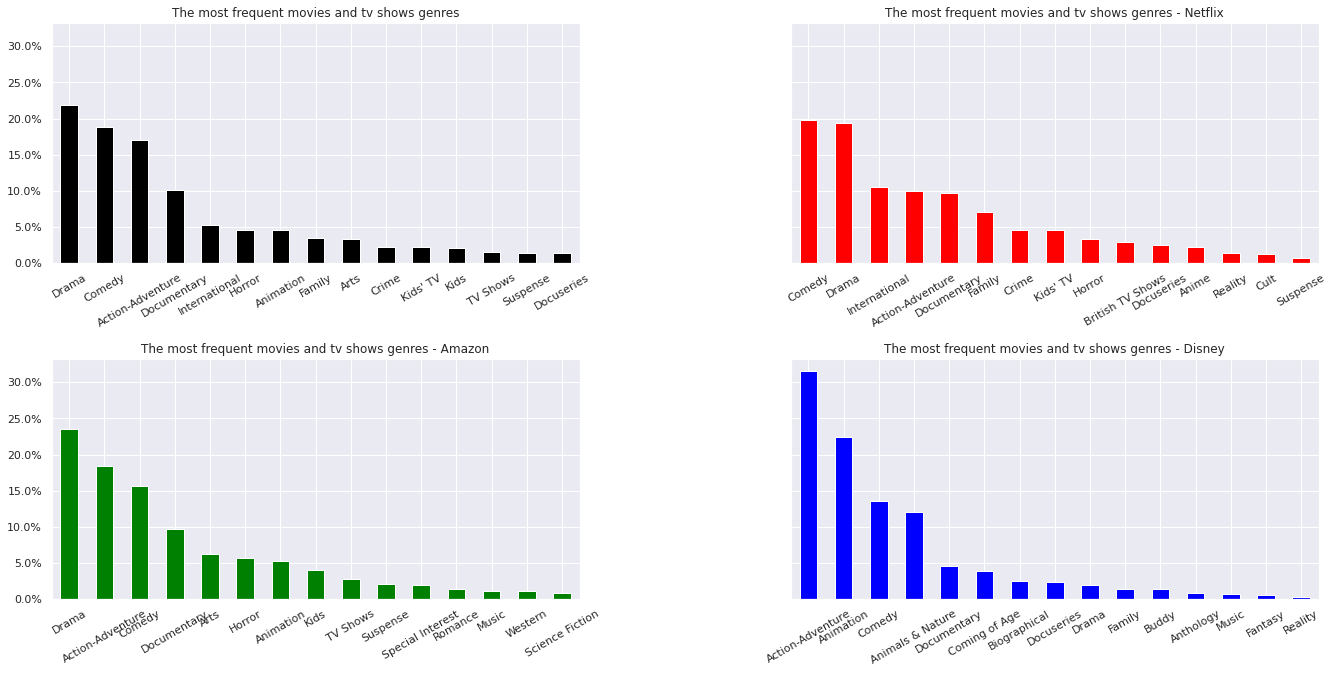

In [ ]:
#Quinze generos mais frequentes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 10), sharey=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

mask = (df.listed_in_main == 'No Data')
fig1 = df['listed_in_main'][~mask].value_counts().nlargest(15)/df['listed_in_main'][~mask].value_counts().nlargest(15).sum()*100
fig1 = fig1.plot(kind='bar', title="The most frequent movies and tv shows genres", color='black', ax=axes[0, 0], rot=30)
fig1.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.listed_in_main == 'No Data')| (df.streaming != 'netflix')
fig2 = df['listed_in_main'][~mask].value_counts().nlargest(15)/df['listed_in_main'][~mask].value_counts().nlargest(15).sum()*100
fig2 = fig2.plot(kind='bar', title="The most frequent movies and tv shows genres - Netflix", color='red', ax=axes[0, 1], rot=30)
fig2.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.listed_in_main == 'No Data')| (df.streaming != 'amazon')
fig3 = df['listed_in_main'][~mask].value_counts().nlargest(15)/df['listed_in_main'][~mask].value_counts().nlargest(15).sum()*100
fig3 = fig3.plot(kind='bar', title="The most frequent movies and tv shows genres - Amazon", color='green', ax=axes[1, 0], rot=30)
fig3.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.listed_in_main == 'No Data')| (df.streaming != 'disney')
fig4 = df['listed_in_main'][~mask].value_counts().nlargest(15)/df['listed_in_main'][~mask].value_counts().nlargest(15).sum()*100
fig4 = fig4.plot(kind='bar', title="The most frequent movies and tv shows genres - Disney", color='blue', ax=axes[1, 1], rot=30)
fig4.yaxis.set_major_formatter(mtick.PercentFormatter())

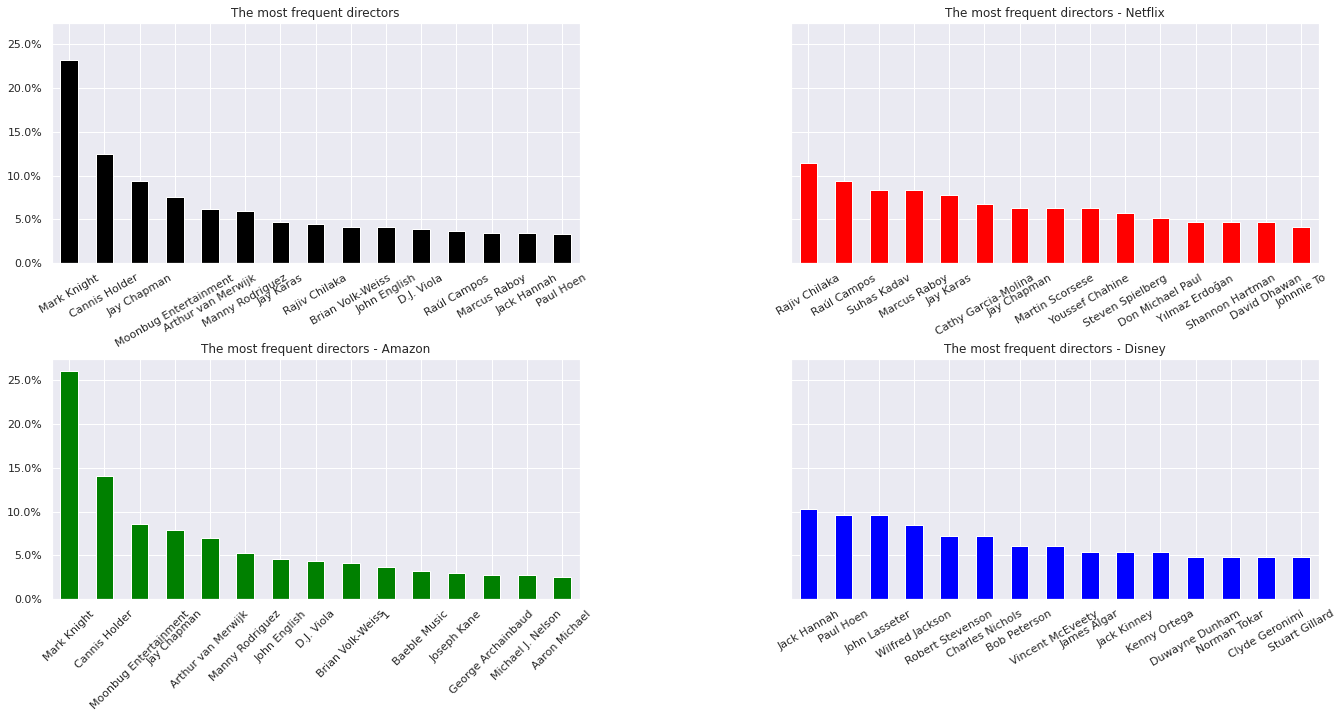

In [ ]:
#Quinze diretores mais frequentes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 10), sharey=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

mask = (df.director_main == 'No Data')
fig1 = df['director_main'][~mask].value_counts().nlargest(15)/df['director_main'][~mask].value_counts().nlargest(15).sum()*100
fig1 = fig1.plot(kind='bar', title="The most frequent directors", color='black', ax=axes[0, 0], rot=30)
fig1.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.director_main == 'No Data')| (df.streaming != 'netflix')
fig2 = df['director_main'][~mask].value_counts().nlargest(15)/df['director_main'][~mask].value_counts().nlargest(15).sum()*100
fig2 = fig2.plot(kind='bar', title="The most frequent directors - Netflix", color='red', ax=axes[0, 1], rot=30)
fig2.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.director_main == 'No Data')| (df.streaming != 'amazon')
fig3 = df['director_main'][~mask].value_counts().nlargest(15)/df['director_main'][~mask].value_counts().nlargest(15).sum()*100
fig3 = fig3.plot(kind='bar', title="The most frequent directors - Amazon", color='green', ax=axes[1, 0], rot=45)
fig3.yaxis.set_major_formatter(mtick.PercentFormatter())

mask = (df.director_main == 'No Data')| (df.streaming != 'disney')
fig4 = df['director_main'][~mask].value_counts().nlargest(15)/df['director_main'][~mask].value_counts().nlargest(15).sum()*100
fig4 = fig4.plot(kind='bar', title="The most frequent directors - Disney", color='blue', ax=axes[1, 1], rot=30)
fig4.yaxis.set_major_formatter(mtick.PercentFormatter())



## 4. Pré-Processamento de dados

### 4.1. Tratar nulos, valores categóricos baixos e tipos de pré-processamento pré modelos

In [ ]:
df.shape

(19925, 23)

In [ ]:
#nulos - eliminar nulos - a partir de um threshold pré-definido
df_preprocessed = PreProcessor.nulos(df, max_nulos)

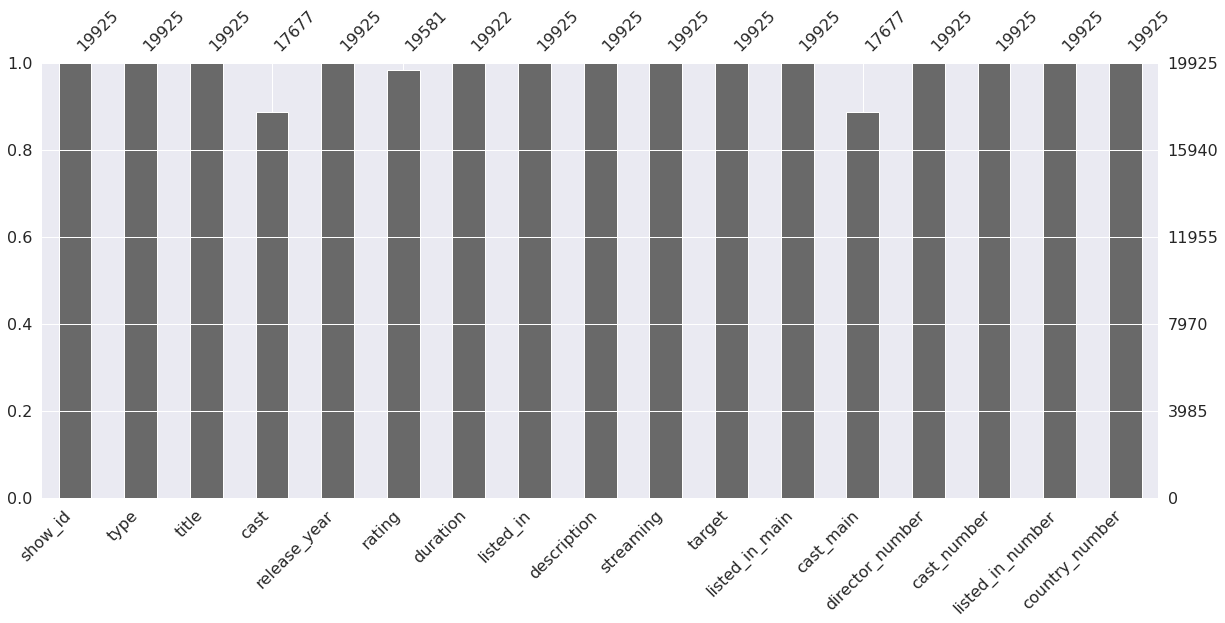

In [ ]:
#verificar quais varaiveis foram mantidas de acordo com o threshold
msno.bar(df_preprocessed,figsize=(20, 8));

In [ ]:
#criar categoria nova baseada na baixa frequência de algumas subcategorias
df_preprocessed = PreProcessor.outros(df_preprocessed, categoricas, corte_samples)

In [ ]:
#deixar o ano de lançamento padronizado
df_preprocessed['release_year'] = df_preprocessed.release_year.dt.strftime("%Y").astype(int)

In [ ]:
df_preprocessed.columns

Index(['show_id', 'type', 'title', 'cast', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'streaming', 'target',
       'listed_in_main', 'cast_main', 'director_number', 'cast_number',
       'listed_in_number', 'country_number'],
      dtype='object')

In [ ]:
df_model = df_preprocessed[['type', 'release_year', 'rating', 'duration', 'listed_in_main', 'cast_main',
         'director_number', 'listed_in_number', 'country_number', 'target']]

In [ ]:
Loader.verify(df_model)

(19925, 10)


,type,release_year,rating,duration,listed_in_main,cast_main,director_number,listed_in_number,country_number,target
0,Movie,2020,Teens - Age above 12,90.0,Documentary,NaN,1,1,1,1.0
1,TV Show,2021,Adults,2.0,International,Ama Qamata,1,3,1,1.0
2,TV Show,2021,Adults,1.0,Crime,Sami Bouajila,1,3,1,1.0
3,TV Show,2021,Adults,1.0,Docuseries,NaN,1,2,1,1.0
4,TV Show,2021,Adults,2.0,International,Mayur More,1,3,1,1.0


### 4.2. Separação em conjunto de treino e conjunto de teste

Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para teste, usando a estratégia train-test-split.

In [ ]:
X = df_model.drop(columns = ['target'])
Y = df_model.target

In [ ]:
X_train, X_test, Y_train, Y_test = PreProcessor.preprocess(dataset= df_model, test_size = 0.20, random_state= 42)

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(15940, 9) (3985, 9) (15940,) (3985,)


In [ ]:
categoricas = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
numericas = df_model.select_dtypes(exclude=['object', 'category']).columns.tolist()

In [ ]:
#tipos de preprocessamento que serão utilizados na etapa seguinte através de uma pipeline
enc = JamesSteinEncoder(cols = categoricas) #uso de encoder para tratar as variaveis categoricas
imp = SimpleImputer(strategy='median') #uso da mediana com imputer
sca = RobustScaler() #para ajudar a tratar outliers

## 5. Modelos de Classificação

### 5.1. Criação e avaliação de modelos: modelos base

Usaremos a validação cruzada 5-fold e avaliaremos os modelos usando a métrica de acurácia balanceada e hamming loss.

Foram escolhidos modelos do scikit-learn que possuem suporte multi-class integrado, incluindo o modelo CatBoost. isso pode ser feito usando um wrapper sklearn, especificamente um wrapper one-vs-rest. Esta técnica constrói um classificador para cada classe, tratando seu problema como uma combinação de problemas de classificação binária, um para cada classe.

Como é que isso funciona? Para uma determinada classe, as amostras marcadas com a classe dada constituem as amostras positivas e todas as outras são tratadas como amostras negativas. Esta é uma abordagem viável, quando o número de classes é pequeno. como o nosso caso

In [ ]:
# Criando pipelines dos modelos
np.random.seed(7) # definindo uma semente global

pipelines = []
pipelines.append(('Pipe_LR', Pipeline([('encoder', enc), ('imputer', imp), ('scaler', sca), ('clf', OneVsRestClassifier(LogisticRegression(random_state= random_state), n_jobs=-1))])))
pipelines.append(('Pipe_RF', Pipeline([('encoder', enc), ('imputer', imp), ('scaler', sca), ('clf', OneVsRestClassifier(RandomForestClassifier(random_state= random_state), n_jobs=-1))])))
pipelines.append(('Pipe_CAT', Pipeline([('encoder', enc), ('imputer', imp), ('scaler', sca), ('clf', OneVsRestClassifier(CatBoostClassifier(random_state= random_state), n_jobs=-1))])))

scoring = {"balanced_accuracy": "balanced_accuracy", 'hamming_loss': make_scorer(hamming_loss), 'roc_auc_ovr_weighted': 'roc_auc_ovr_weighted'}
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=n_folds)
  cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg_accuracy = "%s: %f (%f)" % (name, cv_results.get('test_balanced_accuracy').mean(), cv_results.get('test_balanced_accuracy').std())
  print('balanced_accuracy', msg_accuracy)
  msg_auc = "%s: %f (%f)" % (name, cv_results.get('test_roc_auc_ovr_weighted').mean(), cv_results.get('test_roc_auc_ovr_weighted').std())
  print('test_roc_auc_ovr_weighted', msg_auc)
  msg_hamming = "%s: %f (%f)" % (name, cv_results.get('test_hamming_loss').mean(), cv_results.get('test_balanced_accuracy').std())
  print('hamming_loss', msg_hamming)
  print('')

balanced_accuracy Pipe_LR: 0.592203 (0.008271)
test_roc_auc_ovr_weighted Pipe_LR: 0.859883 (0.002308)
hamming_loss Pipe_LR: 0.242785 (0.008271)

balanced_accuracy Pipe_RF: 0.779030 (0.017857)
test_roc_auc_ovr_weighted Pipe_RF: 0.901444 (0.003767)
hamming_loss Pipe_RF: 0.185759 (0.017857)

balanced_accuracy Pipe_CAT: 0.770816 (0.011463)
test_roc_auc_ovr_weighted Pipe_CAT: 0.896694 (0.003043)
hamming_loss Pipe_CAT: 0.200188 (0.011463)



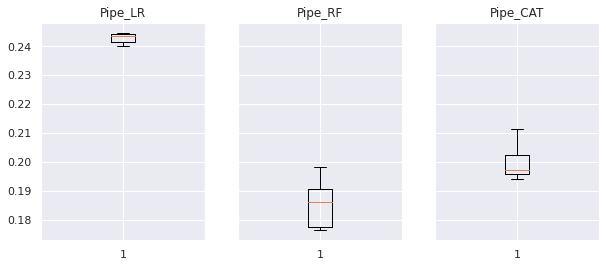

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharey=True)
for i in range(0, 3):
    ax[i].boxplot(results[i]['test_hamming_loss'])
    ax[i].title.set_text(names[i])

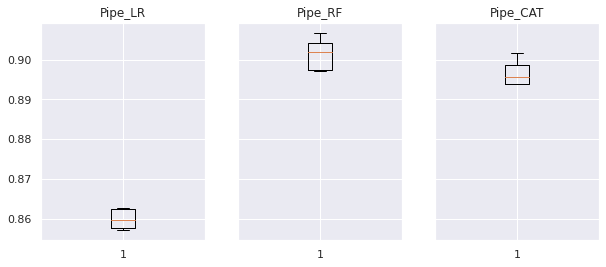

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharey=True)
for i in range(0, 3):
    ax[i].boxplot(results[i]['test_roc_auc_ovr_weighted'])
    ax[i].title.set_text(names[i])

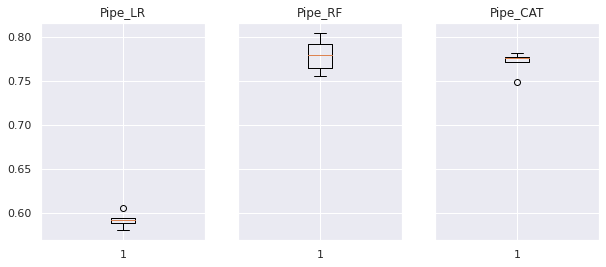

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharey=True)
for i in range(0, 3):
    ax[i].boxplot(results[i]['test_balanced_accuracy'])
    ax[i].title.set_text(names[i])

O modelo de random forest conseguiu ficar ligeiramente melhor do que o de gradient boosting (catboost) de acordo com as métricas. Isto é interessante porque se esperaria o contrário, em geral. Porém o fato do dataset ser pequeno e com poucos atributos, pode ter favorecido um melhor desempenho do random forest. Devido a isto, iremos seguir com o tuning de hiperparâmetros desse modelo

### 5.2 Tuning dos hiperparâmetros
Para o tuning dos hiperparâmetros, irei utilizar o optuna, uma biblioteca python feita especialmente para auxiliar e rodar diferentes combinações de hiperparametros. Os hiperparâmetros considerados foram escritos na hora de criar a classe. Para maiores infromações sobre o Optuna https://optuna.org/


In [ ]:
tune = Model_tuning(X_train, Y_train)

In [ ]:
#para um melhor resultado, talvez um número de trials seja mais recomendável, ou mesmo uma modificação nos hiperparametros
%%capture
rf_study = optuna.create_study(study_name = 'rf', direction='maximize')
rf_study.optimize(tune, n_trials=30)

In [ ]:
#melhores parametros de acordo com balancy_accuracy
print('Number of finished trials:', len(rf_study.trials))
print('Best trial: score {}, params {}'.format(rf_study.best_trial.value, rf_study.best_trial.params))

Number of finished trials: 30
Best trial: score 0.7787237131835865, params {'n_estimators': 410, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True, 'min_samples_leaf': 1, 'random_state': 1, 'criterion': 'gini', 'verbose': 0}


### 5.3 Validação final
Vamos verificar as métricas obtidas pelo modelo final e quais resultados foram obtidos na prática olhando as probabilidades obtidas  

In [ ]:
pipe = Pipeline([('encoder', enc), ('scalar', sca), ('imputer', imp),
                 ('classifier', OneVsRestClassifier(RandomForestClassifier(**rf_study.best_trial.params)))])

pipe.fit(X_train, Y_train)
predictions = pipe.predict(X_test)
cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)

{'fit_time': array([21.40578961, 18.91587853, 19.92560816, 19.00636458, 18.93029523]),
 'score_time': array([0.0867219 , 0.07819486, 0.07805324, 0.07579136, 0.0729003 ]),
 'test_balanced_accuracy': array([0.77690065, 0.78172081, 0.77128337, 0.74888699, 0.77528961]),
 'test_hamming_loss': array([0.2023212 , 0.19730238, 0.19416562, 0.21141782, 0.195734  ]),
 'test_roc_auc_ovr_weighted': array([0.89559851, 0.89378886, 0.89871495, 0.89376935, 0.90159606])}

In [ ]:
classes = pd.DataFrame(pipe.predict_proba(X_test))
classes.rename(columns={0:'Netflix', 1:'Amazon', 2:'Disney'}, inplace=True)
df_results = df[['show_id', 'type', 'title', 'streaming', 'target']].loc[df.index[X_test.index]].reset_index(drop=True)
df_results = pd.concat([df_results, classes], axis=1)

In [ ]:
#amostra da probabilidade dos resultados, podemos ver que o modelo está acertando
df_results

,show_id,type,title,streaming,target,Netflix,Amazon,Disney
0,s8405,Movie,The Gospel of Matthew,amazon,2.0,0.147870,0.852130,0.000000
1,s1089,TV Show,Scenery Channel,amazon,2.0,0.942928,0.029777,0.027295
2,s6534,Movie,Satan's Triangle,amazon,2.0,0.161593,0.824356,0.014052
3,s4442,Movie,Heroine,netflix,1.0,1.000000,0.000000,0.000000
4,s5763,TV Show,Be with Me,netflix,1.0,0.885845,0.011416,0.102740
...,...,...,...,...,...,...,...,...
3980,s1038,Movie,Tuesdays & Fridays,netflix,1.0,0.958937,0.016908,0.024155
3981,s5454,Movie,Little Boxes,netflix,1.0,1.000000,0.000000,0.000000
3982,s2705,Movie,The Florida Project,netflix,1.0,0.731284,0.268716,0.000000
3983,s3053,Movie,Black Sabbath - Paranoid (Classic Album),amazon,2.0,0.399038,0.600962,0.000000


In [ ]:
#verificar títulos presentes em mais de um serviço
df_results[df_results.duplicated(['title'], keep=False)].sort_values(by=['title'])

,show_id,type,title,streaming,target,Netflix,Amazon,Disney
923,s2520,TV Show,Avatar: The Last Airbender,netflix,1.0,0.880266,0.011086,0.108647
2797,s3191,TV Show,Avatar: The Last Airbender,amazon,2.0,0.000000,0.938679,0.061321
596,s6211,Movie,Backtrack,netflix,1.0,0.933962,0.066038,0.000000
3867,s3173,Movie,Backtrack,amazon,2.0,0.000000,1.000000,0.000000
3012,s3100,Movie,Benji,amazon,2.0,0.104583,0.399530,0.495887
2635,s4978,Movie,Benji,netflix,1.0,0.223433,0.765668,0.010899
3864,s1837,Movie,Disconnect,netflix,1.0,0.739857,0.243437,0.016706
321,s8140,Movie,Disconnect,amazon,2.0,1.000000,0.000000,0.000000
3008,s9457,Movie,Driven to Dance,amazon,2.0,0.274502,0.723244,0.002253
2300,s6651,Movie,Driven to Dance,netflix,1.0,0.997567,0.002433,0.000000


Em casos de algumas duplicatas, o modelo parece estar discriminando muito bem, mesmo quando as variavéis deveriam ser iguais, o que dificultaria esta discriminação, talvez alguma variável ainda cause um viés em determinado servico de streaming (por exemplo a contagem de casting pode ser diferente de serviço a serviço). Em uma versão mais definitiva do projeto, isto vai ser analisado cuidadosamente. Duplicatas irão ter que ser unidas e uma média ou uniformização das informações terá que ser realizada para uma discrminação entre os serviços de streaming mais correta

## 5. Exportando modelo final
Verificamos que o catboost possuiu a melhor performance, através do tuning dos hiperparâmetros, criamos nosos modelo final, que pdoera ser exportado via arquivo pickle

In [ ]:
# Preparação do modelo com TODO o dataset (e não apenas a base de treino)
pipe.fit(X, Y)

Pipeline(steps=[('encoder',
                 JamesSteinEncoder(cols=['type', 'rating', 'listed_in_main',
                                         'cast_main'])),
                ('scalar', RobustScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 OneVsRestClassifier(estimator=RandomForestClassifier(max_features='sqrt',
                                                                      n_estimators=410,
                                                                      random_state=1)))])

In [ ]:
#salvar modelo, final em arquivo pickle
with open("final_model", "wb" ) as f:
	pickle.dump(pipe, f)

In [ ]:
#ler arquivo para testar
pipe_load = pickle.load(open('/content/final_model', "rb"))

In [ ]:
#prever probabilidades
pipe_load.predict_proba(X)

array([[0.68509615, 0.31490385, 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       ...,
       [0.01196172, 0.00956938, 0.9784689 ],
       [0.00240964, 0.01445783, 0.98313253],
       [0.        , 0.        , 1.        ]])

Resumo:

Foi trabalhado um problema de classificação multiclass  As etapas abordadas foram:
1. Definição do Problema
2. Importar dados
3. Análise de dados
4. Pré-processamento de dados
4. Modelos de classificação
5. Exportando modelo final

Existem diversas outras possibilidades que ainda podem ser desenvolvidas neste dataset e eu espero implementar futuramente, tal como sistemas de recomendação, e talvez ver o problema sob uma ótica multilabel ou conseguir datasets mais consistentes, algumas variaveis como country tiveram que ser tiradas, pois em um dataset as infos estavam quase nulas (amazon). Ou seja, um resultado anterior excelente, na verdade era devido a um viés nos dados que fazia o modelo reconhecer as infos nulos vindo deste dataset em especifico. Ao verificar as duplicatas, algumas inconsistências nos resultados foram encontradas como descrita acima, em uma versão mais definitiva do projeto, isto será corrigido